# CNN-based 6D pose tracking 

In this notebook, we first briefly introduce the algorithm of CNN-based 6D pose tracking. Then we show how to track a yellow cylinder from the scene.


## Algorithm

**Training**

Input: image pair

* a synthetic RGBD frame of the tracked object rendered with the previous estimated pose onto a black background.

* a synthetic RGBD frame of the tracked object rendered with current pose onto diverse background and with various lighting conditions

Output: pose change between the image pair

After training, the CNN network weights are saved in `model_best.pth.tar`

<img src="../../description/Train.png" alt="Drawing" style="width: 350px;"/>


**Inference**

During inference, at each frame, an image rendered with previous estimated pose and a crop of current frame are given to the pre-trained model. Output is the pose change between previous and current frame. P<sub>current</sub>=P<sub>previous</sub>+$\Delta$P

<img src="../../description/Inference.png" alt="Drawing" style="width: 350px;"/>

## Tracking example

In this example, we show how to use a pre-trained model model_best.pth.tar to track a yellow cylinder.

First, import dependencies

In [1]:
import argparse
from ulaval_6dof_object_tracking.deeptrack.deeptracker import DeepTracker

import sys
import json
import time
import cv2
import numpy as np

from ulaval_6dof_object_tracking.deeptrack.datalogger import DataLogger
import ulaval_6dof_object_tracking.utils.angles as ea
from ulaval_6dof_object_tracking.utils.data import image_blend, angle_distance, compute_axis
import os
from ulaval_6dof_object_tracking.deeptrack.deeptrack_loader import DeepTrackLoader
from pytorch_toolbox.transformations.compose import Compose
from ulaval_6dof_object_tracking.deeptrack.data_augmentation import ToTensor
from PIL import Image
from ulaval_6dof_object_tracking.utils.custom_sequence_loader import CustomSequenceLoader
from ulaval_6dof_object_tracking.utils.sequence_loader import SequenceLoader
from ulaval_6dof_object_tracking.evaluate_sequence import translation_distance, rotation_distance, eval_pose_error, \
    eval_stability, eval_pose_error_save
from ulaval_6dof_object_tracking.deeptrack.deeptrack_loader_base import DeepTrackLoaderBase

import math
from ulaval_6dof_object_tracking.utils.rgbd_dataset import RGBDDataset
from ulaval_6dof_object_tracking.utils.data import compute_2Dboundingbox, show_frames, normalize_scale, \
    combine_view_transform
from ulaval_6dof_object_tracking.utils.transform import Transform
from ulaval_6dof_object_tracking.deeptrack.data_augmentation import NormalizeChannels, OffsetDepth

import matplotlib.pyplot as plt
import seaborn as sns

ESCAPE_KEY = 27

helper functions

In [2]:
def draw_debug(img, pose, tracker, alpha, debug_info):
    if debug_info is not None:
        img_render, bb, _ = debug_info
        img_render = cv2.resize(img_render, (bb[2, 1] - bb[0, 1], bb[1, 0] - bb[0, 0]))
        crop = img[bb[0, 0]:bb[1, 0], bb[0, 1]:bb[2, 1], :]

        h, w, c = crop.shape
        blend = image_blend(img_render[:h, :w, ::-1], crop)
        img[bb[0, 0]:bb[1, 0], bb[0, 1]:bb[2, 1], :] = cv2.addWeighted(img[bb[0, 0]:bb[1, 0], bb[0, 1]:bb[2, 1], :],
                                                                       1 - alpha, blend, alpha, 1)
    else:
        axis = compute_axis(pose, tracker.camera)

        cv2.line(img, tuple(axis[0, ::-1]), tuple(axis[1, ::-1]), (0, 0, 255), 3)
        cv2.line(img, tuple(axis[0, ::-1]), tuple(axis[2, ::-1]), (0, 255, 0), 3)
        cv2.line(img, tuple(axis[0, ::-1]), tuple(axis[3, ::-1]), (255, 0, 0), 3)


Set files path

In [3]:
# Path of images
data_path="../../data/6DposeTracking"
VIDEO_PATH = data_path



# Path of tracking result video
SAVE_VIDEO = True
OUTPUT_PATH = data_path+"/output"
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

# Pre-trained model path
model_folder = data_path
model_name = "model_best.pth.tar"
MODEL_PATH = data_path+"/model_best.pth.tar"

# Files path for rendering synthetic data
SHADER_PATH = "ulaval_6dof_object_tracking/utils/shader"
MODEL_3D_PATH = data_path+"/geometry.ply"


Read in the pose for first frame as initialization

In [4]:
with open(os.path.join(data_path, "trans1.json")) as data_file:
    pose_initial_raw_data = json.load(data_file)

tmpdata = np.array(pose_initial_raw_data['transformation4x4'][0])
transformYZ=np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
pose_initial=np.dot(transformYZ, tmpdata)
previous_pose = Transform.from_matrix(pose_initial)

Load RGBD image sequence

In [5]:
sequence = CustomSequenceLoader(data_path)
camera = sequence.camera

Instantiate DeepTracker(the main class for pose tracking) and load pre_trained network model

In [6]:
tracker = DeepTracker(camera, model_folder)
tracker.load(model_folder, MODEL_PATH, MODEL_3D_PATH, "", SHADER_PATH)

{'bounding_box_width': '198', 'image_size': '174', 'max_radius': '1.4', 'min_radius': '0.8', 'object_width': {}, 'rotation_range': '0.2617993877991494', 'save_type': 'png', 'translation_range': '0.02'}


/home/yanming/workspace/hands-on-with-point-clouds/3D-Applications/pose-estimation-tracking/ulaval_6dof_object_tracking/utils/model_renderer.py:54: RuntimeWarning: invalid value encountered in true_divide
  self.data['a_normal'] = self.data['a_normal'] / np.linalg.norm(self.data['a_normal'], axis=1)[:, np.newaxis]


Create opencv VideoWriter if SAVE_VIDEO is True

In [7]:
if SAVE_VIDEO:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(os.path.join(OUTPUT_PATH, "video.avi"), fourcc, 30, (camera.width, camera.height))


Tracking loop. Press 'esc' to quit the loop.

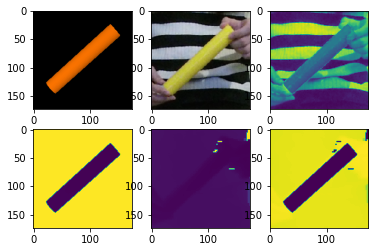

/home/yanming/anaconda3/envs/cumulusworkshop/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/yanming/anaconda3/envs/cumulusworkshop/lib/python3.6/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


pose change: [-0.00095661  0.00353882 -0.00676325 -0.02089588  0.01666888 -0.00037689]
[2]Estimation processing time : 0.35628294944763184


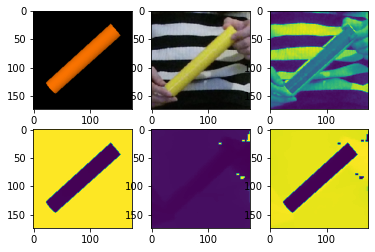

pose change: [ 0.00081071  0.00040256 -0.00438276 -0.00811573  0.00901844  0.00018353]
[3]Estimation processing time : 0.3250882625579834


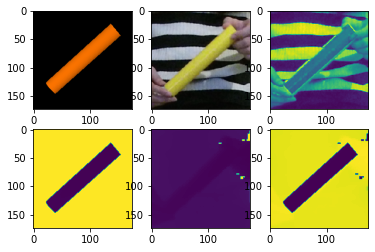

pose change: [ 0.00115992  0.00165378 -0.0022118  -0.00934028  0.00010357  0.01258131]
[4]Estimation processing time : 0.32079029083251953


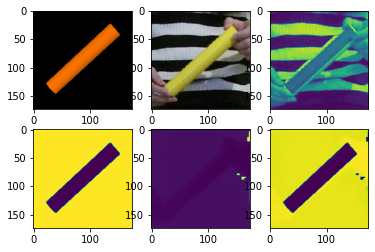

pose change: [ 0.00372963  0.0013764  -0.00103391 -0.00395705  0.0052286  -0.00107539]
[5]Estimation processing time : 0.3630099296569824


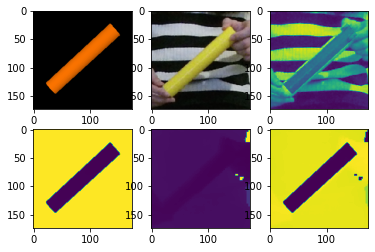

pose change: [ 3.4458302e-05  3.4643567e-04 -2.3612766e-04  4.1082595e-03
 -1.4826164e-03  2.1794145e-03]
[6]Estimation processing time : 0.3108022212982178


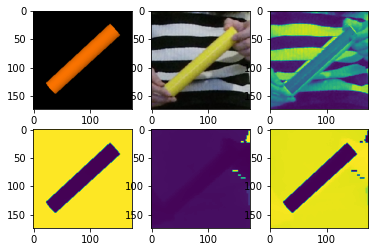

pose change: [ 0.00358035  0.00048168  0.00034546  0.01776179 -0.02013417 -0.00369019]
[7]Estimation processing time : 0.3077871799468994


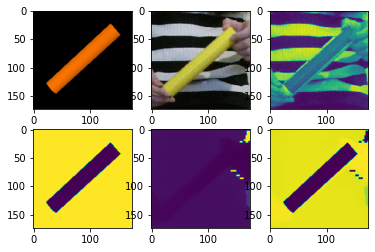

pose change: [-0.00016446  0.00044341  0.00091332 -0.01074771  0.00928052 -0.00804858]
[8]Estimation processing time : 0.312469482421875


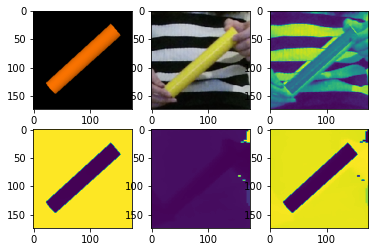

pose change: [ 0.00296398 -0.00078383 -0.00137569  0.00233071 -0.01166659  0.00406129]
[9]Estimation processing time : 0.3171510696411133
pressed key id : 27, char : []


In [8]:
debug_info = None
start_index = 2
end_index = 200
step = 1

for i in range(start_index, end_index, step):
    # read in current RGB and depth
    current_rgb, current_depth = sequence[i]
    
    # Screen is the copy of original color image, for visualization
    screen = current_rgb.copy()

    # record start time 
    start_time = time.time()
    
    # estimate current pose using previous pose and current rgbd
    predicted_pose, debug_info = tracker.estimate_current_pose(previous_pose, current_rgb, current_depth, debug=True)

    previous_pose = predicted_pose
    print("[{}]Estimation processing time : {}".format(i, time.time() - start_time))
       
    # Augment model with estimated pose onto the original color image
    draw_debug(screen, previous_pose, tracker, 1, debug_info)
    cv2.imshow("Debug", screen[:, :, ::-1])
    if SAVE_VIDEO:
        out.write(screen[:, :, ::-1])
        
    # key handling
    key = cv2.waitKey(1)
    key_chr = chr(key & 255)
    if key != -1:
        print("pressed key id : {}, char : [{}]".format(key, key_chr))
       
    if key == ESCAPE_KEY or i==(end_index-1):
        cv2.destroyAllWindows()
        break

if SAVE_VIDEO:
    out.release()
